# Notebook para o PAN - Atribuição Autoral - 2018

In [1]:
%matplotlib inline
#python basic libs
from __future__ import print_function

from tempfile import mkdtemp
from shutil import rmtree
import os;
from os.path import join as pathjoin;

import re;
import glob;
import json;
import codecs;
from collections import defaultdict;
import pprint;
import warnings;


from pprint import pprint
from time import time
import logging


#data analysis libs
import numpy as np;
import pandas as pd;
import seaborn as sn;
import matplotlib.pyplot as plt;
import random;

#machine learning libs
#feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#preprocessing and transformation
from sklearn.preprocessing import normalize, MaxAbsScaler, MinMaxScaler;
from sklearn.preprocessing import LabelBinarizer, LabelEncoder;
from sklearn.decomposition import PCA;
from sklearn.metrics.pairwise import cosine_similarity;


from sklearn.base import BaseEstimator, ClassifierMixin

#classifiers
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#model valuation
from sklearn.model_selection import train_test_split;
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score;

In [2]:
import seaborn as sns;
sns.set(color_codes=True);
from pandas.plotting import scatter_matrix

In [3]:
import platform; print(platform.platform())
print("NumPy", np.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)

Darwin-17.5.0-x86_64-i386-64bit
NumPy 1.14.2
SciPy 1.0.1
Scikit-Learn 0.19.1


### paths configuration

In [4]:
baseDir = '/Users/joseeleandrocustodio/Dropbox/mestrado/02 - Pesquisa/code';

inputDir= pathjoin(baseDir,'pan18aa');
outputDir= pathjoin(baseDir,'out',"oficial");
if not os.path.exists(outputDir):
    os.mkdir(outputDir);

## loading the dataset

In [5]:
def readCollectionsOfProblems(path):
    # Reading information about the collection
    infocollection = path+os.sep+'collection-info.json'
    with open(infocollection, 'r') as f:
        problems  = [
            {
                'problem': attrib['problem-name'],
                'language': attrib['language'],
                'encoding': attrib['encoding'],
            }
            for attrib in json.load(f)
            
        ]
    return problems;

In [6]:
def readProblem(path, problem):
    # Reading information about the problem
    infoproblem = path+os.sep+problem+os.sep+'problem-info.json'
    candidates = []
    with open(infoproblem, 'r') as f:
        fj = json.load(f)
        unk_folder = fj['unknown-folder']
        for attrib in fj['candidate-authors']:
            candidates.append(attrib['author-name'])
    return unk_folder, candidates;

In [7]:
def read_files(path,label):
    # Reads all text files located in the 'path' and assigns them to 'label' class
    files = glob.glob(pathjoin(path,label,'*.txt'))
    texts=[]
    for i,v in enumerate(files):
        f=codecs.open(v,'r',encoding='utf-8')
        texts.append((f.read(),label, os.path.basename(v)))
        f.close()
    return texts

In [8]:
problems = readCollectionsOfProblems(inputDir);

In [9]:
for index,problem in enumerate(problems):
    unk_folder, candidates_folder = readProblem(inputDir, problem['problem']); 
    problem['candidates_folder_count'] = len(candidates_folder);
    problem['candidates'] = [];
    for candidate in candidates_folder:
        problem['candidates'].extend(read_files(pathjoin(inputDir, problem['problem']),candidate));
    
    problem['unknown'] = read_files(pathjoin(inputDir, problem['problem']),unk_folder);    

In [10]:
pd.DataFrame(problems)

,candidates,candidates_folder_count,encoding,language,problem,unknown
0,"[(graceful ones.\n\n""One more,"" Marvelous said...",20,UTF-8,en,problem00001,"[(after all, his best friends. And what in the..."
1,"[(a mission.""\n\nJensen just raises an eyebrow...",5,UTF-8,en,problem00002,"[(“Potter was attractive,” Draco thought, sigh..."
2,[(qui l'avait tué mais tout était de la faute ...,20,UTF-8,fr,problem00003,[(son réveil. Sa main pulse et Draco frotte l'...
3,[(. Le canapé est vide et lorsqu'il passe deva...,5,UTF-8,fr,problem00004,"[(abasourdie.\n\nTout d'abord, elle crut que s..."
4,"[(Eppure lui la mappa l’aveva stampata, dannaz...",20,UTF-8,it,problem00005,[(– Oh. Cazzo.\nSirius era così sconvolto che ...
5,[(Yato ha trovato una lettera sul suo comodino...,5,UTF-8,it,problem00006,"[(così la tua vista, Moony?\n– Cercavo di esse..."
6,[(zmienił zdanie. Niech się stworzonko pobawi....,20,UTF-8,pl,problem00007,"[(dawniej pełna radości i ciepła, a teraz wiec..."
7,"[(Słowem, które Sherlock najczęściej słyszał w...",5,UTF-8,pl,problem00008,"[(, uderzającego o żebra niczym dzwon- niemal ..."
8,[(pero no lo ama como ama a Guignol –explicó e...,20,UTF-8,sp,problem00009,[(–La nariz puntiaguda del elfo casi rozaba el...
9,"[(incapaz de señalar un momento exacto, un pun...",5,UTF-8,sp,problem00010,[(tan parecidas hizo que su trasero latiese de...


In [11]:
#*******************************************************************************************************

def eval_measures(gt, pred):
    """Compute macro-averaged F1-scores, macro-averaged precision, 
    macro-averaged recall, and micro-averaged accuracy according the ad hoc
    rules discussed at the top of this file.
    Parameters
    ----------
    gt : dict
        Ground truth, where keys indicate text file names
        (e.g. `unknown00002.txt`), and values represent
        author labels (e.g. `candidate00003`)
    pred : dict
        Predicted attribution, where keys indicate text file names
        (e.g. `unknown00002.txt`), and values represent
        author labels (e.g. `candidate00003`)
    Returns
    -------
    f1 : float
        Macro-averaged F1-score
    precision : float
        Macro-averaged precision
    recall : float
        Macro-averaged recall
    accuracy : float
        Micro-averaged F1-score
    """

    actual_authors = list(gt.values())
    encoder = LabelEncoder().fit(['<UNK>'] + actual_authors)

    text_ids, gold_authors, silver_authors = [], [], []
    for text_id in sorted(gt):
        text_ids.append(text_id)
        gold_authors.append(gt[text_id])
        try:
            silver_authors.append(pred[text_id])
        except KeyError:
            # missing attributions get <UNK>:
            silver_authors.append('<UNK>')

    assert len(text_ids) == len(gold_authors)
    assert len(text_ids) == len(silver_authors)

    # replace non-existent silver authors with '<UNK>':
    silver_authors = [a if a in encoder.classes_ else '<UNK>' 
                      for a in silver_authors]

    gold_author_ints   = encoder.transform(gold_authors)
    silver_author_ints = encoder.transform(silver_authors)

    # get F1 for individual classes (and suppress warnings):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        f1 = f1_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        precision = precision_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        recall = recall_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        accuracy = accuracy_score(gold_author_ints,
                  silver_author_ints)

    return f1,precision,recall,accuracy


In [12]:
def evaluate(ground_truth_file,predictions_file):
    # Calculates evaluation measures for a single attribution problem
    gt = {}
    with open(ground_truth_file, 'r') as f:
        for attrib in json.load(f)['ground_truth']:
            gt[attrib['unknown-text']] = attrib['true-author']

    pred = {}
    with open(predictions_file, 'r') as f:
        for attrib in json.load(f):
            if attrib['unknown-text'] not in pred:
                pred[attrib['unknown-text']] = attrib['predicted-author']
    f1,precision,recall,accuracy =  eval_measures(gt,pred)
    return f1, precision, recall, accuracy

In [13]:
from sklearn.base import BaseEstimator
from scipy.sparse import issparse


class DenseTransformer(BaseEstimator):
    """Convert a sparse array into a dense array."""

    def __init__(self, return_copy=True):
        self.return_copy = return_copy
        self.is_fitted = False

    def transform(self, X, y=None):
        if issparse(X):
            return X.toarray()
        elif self.return_copy:
            return X.copy()
        else:
            return X

    def fit(self, X, y=None):
        self.is_fitted = True
        return self

    def fit_transform(self, X, y=None):
        return self.transform(X=X, y=y)

In [14]:
def runML(problem):
    print ("\nProblem: %s,  language: %s, " %(problem['problem'],problem['language']))
    
    train_docs, train_labels, _   = zip(*problem['candidates'])
    problem['training_docs_size'] = len(train_docs);
    test_docs, _, test_filename   = zip(*problem['unknown'])
    
    pipeline = Pipeline([
        ('vect',   TfidfVectorizer(analyzer='word',
                                   norm='l1',
                                   max_df=1.0,
                                   ngram_range=(1,3),
                                   lowercase =True,
                                   sublinear_tf=True)),
        ('dense',  DenseTransformer()),
        ('scaler', MaxAbsScaler()),
        ('transf', PCA(0.9999)),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ])
    
    
    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'vect__min_df':(2,0.01,0.05,0.1)
    }
    
    grid_search = GridSearchCV(pipeline,
                               parameters,
                               cv=5,
                               scoring='f1_macro',
                               n_jobs=-1,
                               verbose=False
                               )
    
    print("Performing grid search...")
    t0 = time()
    grid_search.fit(train_docs, train_labels)
    print("done in %0.3fs" % (time() - t0))

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    train_pred=grid_search.predict(train_docs);
    test_pred=grid_search.predict(test_docs);
    
    
    # Writing output file
    out_data=[]
    for i,v in enumerate(test_pred):
        out_data.append({'unknown-text': test_filename[i],'predicted-author': v})
    answerFile = pathjoin(outputDir,'answers-'+problem['problem']+'.json');
    with open(answerFile, 'w') as f:
        json.dump(out_data, f, indent=4)
        #allProblems.extend(out_data)
    
    
    #evaluation train
    f1,precision,recall,accuracy=evaluate(
                pathjoin(inputDir, problem['problem'], 'ground-truth.json'),
                answerFile)
    
    return {
                'problem-name'  :       problem['problem'],
                "language"      :       problem['language'],
                'AuthorCount'   :       len(set(train_labels)),
                "train_doc_size":       len(train_docs),
                "train_caract_per_doc": sum([len(l) for l in train_docs])/len(train_docs),
                "test_doc_size" :       len(test_docs),
                "test_caract_per_doc":  sum([len(l) for l in test_docs])/len(test_docs),
                
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3),
                
        }, grid_search.cv_results_, best_parameters;

### examinando o parametro min_df isoladamente

In [54]:
result = [];
cv_result = [];
best_parameters = [];
for problem in problems:
    r, c, b = runML(problem);
    result.append(r);
    cv_result.append(c);
    b['problem'] = problem['problem'];
    best_parameters.append(b);


Problem: problem00001,  language: en, 
Performing grid search...
done in 39.641s
Best score: 0.653
Best parameters set:
	vect__min_df: 2

Problem: problem00002,  language: en, 
Performing grid search...
done in 12.632s
Best score: 0.939
Best parameters set:
	vect__min_df: 0.01

Problem: problem00003,  language: fr, 
Performing grid search...
done in 36.503s
Best score: 0.686
Best parameters set:
	vect__min_df: 2

Problem: problem00004,  language: fr, 
Performing grid search...
done in 12.361s
Best score: 0.810
Best parameters set:
	vect__min_df: 0.01

Problem: problem00005,  language: it, 
Performing grid search...
done in 37.516s
Best score: 0.600
Best parameters set:
	vect__min_df: 2

Problem: problem00006,  language: it, 
Performing grid search...
done in 12.988s
Best score: 0.832
Best parameters set:
	vect__min_df: 0.01

Problem: problem00007,  language: pl, 
Performing grid search...
done in 40.408s
Best score: 0.712
Best parameters set:
	vect__min_df: 2

Problem: problem00008,  

In [72]:
pd.DataFrame(best_parameters)[['problem','vect__min_df']]

,problem,vect__min_df
0,problem00001,2.00
1,problem00002,0.01
2,problem00003,2.00
3,problem00004,0.01
4,problem00005,2.00
5,problem00006,0.01
6,problem00007,2.00
7,problem00008,0.10
8,problem00009,2.00
9,problem00010,2.00


### analisando os demais parametros

In [14]:
def runML(problem):
    print ("\nProblem: %s,  language: %s, " %(problem['problem'],problem['language']))
    
    train_docs, train_labels, _   = zip(*problem['candidates'])
    problem['training_docs_size'] = len(train_docs);
    test_docs, _, test_filename   = zip(*problem['unknown'])
    
    pipeline = Pipeline([
        ('vect',   TfidfVectorizer(analyzer='word',
                                   norm='l1',
                                   min_df=2,
                                   max_df=1.0,
                                   smooth_idf=True,
                                   lowercase =True,
                                   sublinear_tf=True)),
        ('dense',  DenseTransformer()),
        ('scaler', MaxAbsScaler()),
        ('transf', PCA()),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ])
    
    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'vect__ngram_range':((1,1),(1,2),(1,3)),
        'vect__sublinear_tf':(True, False),
        'vect__norm':('l1','l2',None),
        'transf__n_components': (0.1,0.25,0.5,0.75,0.9,0.999),
    }
    
    grid_search = GridSearchCV(pipeline,
                               parameters,
                               cv=5,
                               scoring='f1_macro',
                               n_jobs=-1,
                               verbose=False
                               )
    
    print("Performing grid search...")
    t0 = time()
    grid_search.fit(train_docs, train_labels)
    print("done in %0.3fs" % (time() - t0))

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    train_pred=grid_search.predict(train_docs);
    test_pred=grid_search.predict(test_docs);
    
    
    # Writing output file
    out_data=[]
    for i,v in enumerate(test_pred):
        out_data.append({'unknown-text': test_filename[i],'predicted-author': v})
    answerFile = pathjoin(outputDir,'answers-'+problem['problem']+'.json');
    with open(answerFile, 'w') as f:
        json.dump(out_data, f, indent=4)
        #allProblems.extend(out_data)
    
    
    #evaluation train
    f1,precision,recall,accuracy=evaluate(
                pathjoin(inputDir, problem['problem'], 'ground-truth.json'),
                answerFile)
    
    return {
                'problem-name'  :       problem['problem'],
                "language"      :       problem['language'],
                'AuthorCount'   :       len(set(train_labels)),
                "train_doc_size":       len(train_docs),
                "train_caract_per_doc": sum([len(l) for l in train_docs])/len(train_docs),
                "test_doc_size" :       len(test_docs),
                "test_caract_per_doc":  sum([len(l) for l in test_docs])/len(test_docs),
                
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3),
                
        }, grid_search.cv_results_, best_parameters;

In [15]:
result = [];
cv_result = [];
best_parameters = [];
for problem in problems:
    r, c, b = runML(problem);
    result.append(r);
    cv_result.append(c);
    b['problem'] = problem['problem'];
    best_parameters.append(b);


Problem: problem00001,  language: en, 
Performing grid search...


/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

done in 218.240s
Best score: 0.655
Best parameters set:
	transf__n_components: 0.9
	vect__ngram_range: (1, 3)
	vect__norm: 'l1'
	vect__sublinear_tf: True

Problem: problem00002,  language: en, 
Performing grid search...
done in 50.784s
Best score: 0.909
Best parameters set:
	transf__n_components: 0.999
	vect__ngram_range: (1, 3)
	vect__norm: 'l2'
	vect__sublinear_tf: True

Problem: problem00003,  language: fr, 
Performing grid search...
done in 876.089s
Best score: 0.696
Best parameters set:
	transf__n_components: 0.999
	vect__ngram_range: (1, 2)
	vect__norm: 'l1'
	vect__sublinear_tf: True

Problem: problem00004,  language: fr, 
Performing grid search...
done in 52.429s
Best score: 0.860
Best parameters set:
	transf__n_components: 0.999
	vect__ngram_range: (1, 1)
	vect__norm: 'l1'
	vect__sublinear_tf: True

Problem: problem00005,  language: it, 
Performing grid search...
done in 244.110s
Best score: 0.628
Best parameters set:
	transf__n_components: 0.999
	vect__ngram_range: (1, 2)
	vec

In [16]:
df=pd.DataFrame(result)[['problem-name',
                     "language",
                     'AuthorCount',
                     "train_doc_size","train_caract_per_doc",
                     "test_doc_size", "test_caract_per_doc",
                     'macro-f1','macro-precision','macro-recall' ,'micro-accuracy']]


In [17]:
df

,problem-name,language,AuthorCount,train_doc_size,train_caract_per_doc,test_doc_size,test_caract_per_doc,macro-f1,macro-precision,macro-recall,micro-accuracy
0,problem00001,en,20,140,4327,105,4370,0.435,0.453,0.563,0.562
1,problem00002,en,5,35,4342,21,4296,0.577,0.547,0.650,0.762
2,problem00003,fr,20,140,4492,49,4508,0.541,0.597,0.603,0.592
3,problem00004,fr,5,35,4522,21,4532,0.573,0.657,0.667,0.571
4,problem00005,it,20,140,4720,80,4787,0.571,0.553,0.765,0.625
5,problem00006,it,5,35,4847,46,4765,0.492,0.526,0.594,0.652
6,problem00007,pl,20,140,5145,103,5200,0.464,0.469,0.569,0.534
7,problem00008,pl,5,35,5049,15,5214,0.789,0.780,0.800,0.933
8,problem00009,sp,20,140,4794,117,4788,0.691,0.690,0.741,0.675
9,problem00010,sp,5,35,4955,64,4827,0.613,0.715,0.613,0.703


In [18]:
print(df[["macro-f1"]].reset_index().to_latex(index=False).replace("     "," "))

\begin{tabular}{rr}
\toprule
 index &  macro-f1 \\
\midrule
 0 & 0.435 \\
 1 & 0.577 \\
 2 & 0.541 \\
 3 & 0.573 \\
 4 & 0.571 \\
 5 & 0.492 \\
 6 & 0.464 \\
 7 & 0.789 \\
 8 & 0.691 \\
 9 & 0.613 \\
\bottomrule
\end{tabular}



In [19]:
pd.DataFrame(result)[['macro-f1']].describe()

,macro-f1
count,10.000000
mean,0.574600
std,0.105769
min,0.435000
25%,0.504250
50%,0.572000
75%,0.604000
max,0.789000


In [20]:
languages={
    'en':'inglesa',
    'sp':'espanhola',
    'it':'italiana',
    'pl':'polonesa',
    'fr':'francesa'
}

In [21]:
cv_result2 = [];
dfCV = pd.DataFrame();
for i, c in enumerate(cv_result):
    temp = pd.DataFrame(c);
    temp['problem'] = i+1;
    temp['language'] = languages[problems[i]['language']]
    dfCV = dfCV.append(temp);

for p in ['param_transf__n_components',
    'mean_test_score','std_test_score','mean_train_score',   
    'split0_test_score','split0_train_score',
    'split1_test_score','split1_train_score',
    'split2_test_score','split2_train_score',
    'split3_test_score','split3_train_score',
    'split4_test_score','split4_train_score']:
    dfCV[p]=dfCV[p].astype(np.float32);

    
dfCV =dfCV[[
    'problem',
    'language',
    'rank_test_score',
    'param_transf__n_components',
    'param_vect__ngram_range',
    'param_vect__sublinear_tf',
    'param_vect__norm',
    'mean_test_score',   
    'std_test_score',
    'mean_train_score',   

    'split0_test_score','split0_train_score',
    'split1_test_score','split1_train_score',
    'split2_test_score','split2_train_score',
    'split3_test_score','split3_train_score',
    'split4_test_score','split4_train_score',

    'mean_score_time',
    'mean_fit_time',
    'std_fit_time',
    'std_score_time',
    'std_train_score',
]];

dfCV.rename(columns={
    'param_transf__n_components':'PCA_componentes',
    'param_vect__ngram_range':'ngram_range',
    'param_vect__sublinear_tf':'sublinear_tf',
    'param_vect__smooth_idf':'smooth_idf',
    'param_vect__norm':'norm'
},inplace=True);

#print('\',\n\''.join(dfCV.columns))

/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **w

In [22]:
dfCV.to_csv('PANAA2018_WORD.csv', index=False)

In [15]:
dfCV = pd.read_csv('PANAA2018_WORD.csv')

In [16]:
dfCV.head()

,problem,language,rank_test_score,PCA_componentes,ngram_range,sublinear_tf,norm,mean_test_score,std_test_score,mean_train_score,...,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,mean_score_time,mean_fit_time,std_fit_time,std_score_time,std_train_score
0,1,inglesa,83,0.1,"(1, 1)",True,l1,0.203776,0.092235,0.657004,...,0.636694,0.033333,0.678485,0.241667,0.621748,0.060196,0.641367,0.107349,0.020426,0.036499
1,1,inglesa,92,0.1,"(1, 1)",False,l1,0.167551,0.068010,0.639273,...,0.608891,0.039286,0.642871,0.261667,0.614682,0.038032,0.358350,0.062163,0.010611,0.024817
2,1,inglesa,85,0.1,"(1, 1)",True,l2,0.190501,0.060261,0.675101,...,0.673753,0.070000,0.668075,0.150000,0.668798,0.048739,0.310696,0.060583,0.015144,0.023613
3,1,inglesa,88,0.1,"(1, 1)",False,l2,0.182619,0.056004,0.554696,...,0.569667,0.050000,0.561090,0.203333,0.518049,0.043320,0.281166,0.026685,0.020432,0.018582
4,1,inglesa,78,0.1,"(1, 1)",True,NaN,0.220675,0.083194,0.670919,...,0.678995,0.083333,0.723990,0.233333,0.623060,0.039549,0.267199,0.025022,0.011557,0.037250


In [17]:
(dfCV[dfCV.rank_test_score == 1])[
    ['problem',
     'language',
    'rank_test_score',
    'mean_test_score',
    'std_test_score',
    'ngram_range',
    'sublinear_tf',
    'PCA_componentes']
].sort_values(by=[
    'problem',
    'mean_test_score',
    'ngram_range',
    'sublinear_tf',
    'PCA_componentes'
], ascending=[True, False,False,False,False])

,problem,language,rank_test_score,mean_test_score,std_test_score,ngram_range,sublinear_tf,PCA_componentes
84,1,inglesa,1,0.655068,0.081579,"(1, 3)",True,0.900
212,2,inglesa,1,0.908571,0.088853,"(1, 3)",True,0.999
312,3,francesa,1,0.696429,0.153399,"(1, 2)",True,0.999
414,4,francesa,1,0.860000,0.171825,"(1, 1)",True,0.999
528,5,italiana,1,0.628016,0.085412,"(1, 2)",True,0.999
616,6,italiana,1,0.893333,0.110410,"(1, 1)",True,0.900
598,6,italiana,1,0.893333,0.110410,"(1, 1)",True,0.750
617,6,italiana,1,0.893333,0.110410,"(1, 1)",False,0.900
746,7,polonesa,1,0.750000,0.104228,"(1, 2)",True,0.999
860,8,polonesa,1,0.828571,0.181203,"(1, 3)",True,0.999


In [18]:
dfCV.pivot_table(
            index=['problem','language','PCA_componentes'],
            columns=['norm','sublinear_tf', 'ngram_range'],
            values='mean_test_score'
        )

norm                                     l1                                \
sublinear_tf                          False                         True    
ngram_range                          (1, 1)    (1, 2)    (1, 3)    (1, 1)   
problem language  PCA_componentes                                           
1       inglesa   0.100            0.167551  0.146697  0.135759  0.203776   
                  0.250            0.262653  0.286065  0.294096  0.332302   
                  0.500            0.422925  0.544512  0.539422  0.464116   
                  0.750            0.537936  0.605782  0.569036  0.545272   
                  0.900            0.557222  0.629184  0.622449  0.594082   
                  0.999            0.589048  0.630714  0.612857  0.596576   
2       inglesa   0.100            0.465714  0.252653  0.357778  0.442177   
                  0.250            0.497143  0.541905  0.571255  0.513160   
                  0.500            0.777143  0.796191  0.750748  0.723810   
                  0.750            0.805714  0.740952  0.696190  0.805714   
                  0.900            0.805714  0.716190  0.775238  0.843810   
                  0.999            0.843810  0.841905  0.813333  0.843810   
3       francesa  0.100            0.281667  0.192835  0.199059  0.280595   
                  0.250            0.466011  0.450195  0.413856  0.470635   
                  0.500            0.527925  0.585340  0.499128  0.624830   
                  0.750            0.593163  0.592687  0.580204  0.623571   
                  0.900            0.638810  0.643844  0.627483  0.637925   
                  0.999            0.625476  0.665952  0.675578  0.645068   
4       francesa  0.100            0.376562  0.206667  0.175238  0.242276   
                  0.250            0.671429  0.672789  0.617143  0.668571   
                  0.500            0.770476  0.729524  0.696190  0.770476   
                  0.750            0.770476  0.764762  0.726667  0.800952   
                  0.900            0.800952  0.802857  0.711429  0.829524   
                  0.999            0.800952  0.833333  0.774286  0.860000   
5       italiana  0.100            0.163881  0.096068  0.084731  0.174473   
                  0.250            0.307942  0.344305  0.326419  0.314702   
                  0.500            0.434422  0.461848  0.466939  0.471020   
                  0.750            0.528243  0.544127  0.542914  0.527007   
                  0.900            0.540612  0.594274  0.536190  0.559218   
                  0.999            0.555941  0.624342  0.595612  0.555816   
6       italiana  0.100            0.255329  0.232381  0.290159  0.193333   
                  0.250            0.740952  0.525986  0.432336  0.834286   
                  0.500            0.746667  0.826667  0.796191  0.803810   
                  0.750            0.746667  0.836190  0.817143  0.803810   
                  0.900            0.794286  0.744762  0.786667  0.834286   
                  0.999            0.765714  0.744762  0.744762  0.832381   
7       polonesa  0.100            0.265329  0.205661  0.222120  0.337296   
                  0.250            0.485204  0.391261  0.391073  0.559953   
                  0.500            0.617755  0.630374  0.595442  0.668163   
                  0.750            0.657449  0.690034  0.657143  0.655714   
                  0.900            0.662041  0.711905  0.703878  0.694762   
                  0.999            0.659524  0.687143  0.671735  0.678333   
8       polonesa  0.100            0.306984  0.316190  0.291429  0.314286   
                  0.250            0.649524  0.609524  0.609524  0.641905   
                  0.500            0.651429  0.608571  0.592381  0.643810   
                  0.750            0.643810  0.678095  0.646667  0.700952   
                  0.900            0.662857  0.727619  0.758095  0.702857   
                  0.999            0.689524  0.724762  0.724762  0.727619

In [19]:
pd.options.display.precision = 3  
print(u"\\begin{table}[h]\n\\centering\n\\caption{Medida F1 para os parâmetros }")

print(re.sub(r'[ ]{2,}',' ',dfCV[dfCV.PCA_componentes >= 0.999].pivot_table(
        index=['problem','language','sublinear_tf','norm'],
        columns=['ngram_range'],
        values='mean_test_score'
    ).to_latex()))
print ("\label{tab:modelocaracter}")
print(r"\end{table}")

\begin{table}[h]
\centering
\caption{Medida F1 para os parâmetros }
\begin{tabular}{llllrrr}
\toprule
 & & & ngram\_range & (1, 1) & (1, 2) & (1, 3) \\
problem & language & sublinear\_tf & norm & & & \\
\midrule
1 & inglesa & False & l1 & 0.589 & 0.631 & 0.613 \\
 & & & l2 & 0.563 & 0.574 & 0.598 \\
 & & True & l1 & 0.597 & 0.630 & 0.653 \\
 & & & l2 & 0.596 & 0.622 & 0.613 \\
2 & inglesa & False & l1 & 0.844 & 0.842 & 0.813 \\
 & & & l2 & 0.844 & 0.804 & 0.880 \\
 & & True & l1 & 0.844 & 0.832 & 0.870 \\
 & & & l2 & 0.806 & 0.821 & 0.909 \\
3 & francesa & False & l1 & 0.625 & 0.666 & 0.676 \\
 & & & l2 & 0.590 & 0.663 & 0.630 \\
 & & True & l1 & 0.645 & 0.696 & 0.686 \\
 & & & l2 & 0.655 & 0.665 & 0.688 \\
4 & francesa & False & l1 & 0.801 & 0.833 & 0.774 \\
 & & & l2 & 0.770 & 0.774 & 0.746 \\
 & & True & l1 & 0.860 & 0.795 & 0.765 \\
 & & & l2 & 0.830 & 0.793 & 0.734 \\
5 & italiana & False & l1 & 0.556 & 0.624 & 0.596 \\
 & & & l2 & 0.525 & 0.567 & 0.578 \\
 & & True & l1 & 0.556 &

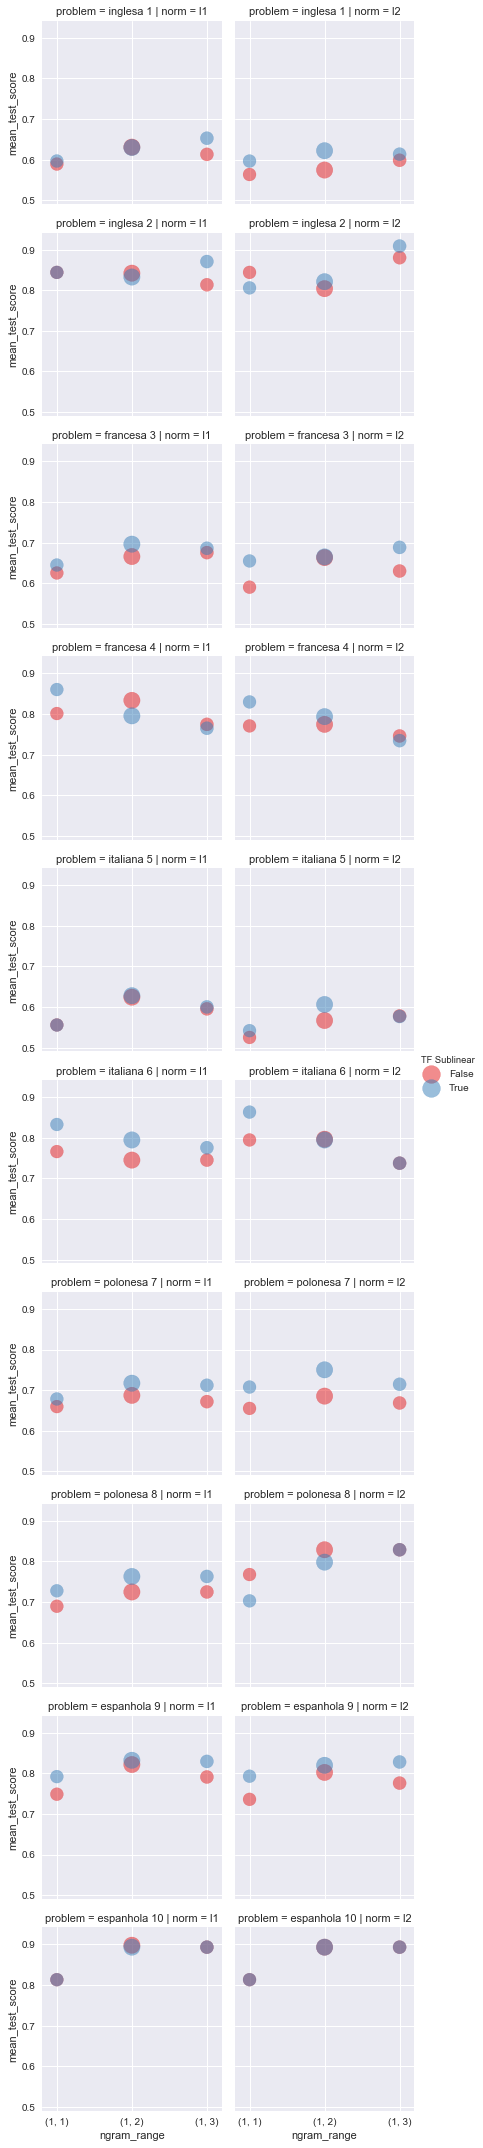

In [20]:
d = dfCV[dfCV.PCA_componentes > 0.9].rename(columns={'language':u'Língua', 'sublinear_tf':'TF Sublinear'})
d = d [ d.norm.isna() == False]
d['autorNumber'] = d.problem.map(lambda x: 20 if x % 2==0  else 5)
d.problem = d.apply(lambda x: x[u'Língua'] +" "+ str(x[u'problem']), axis=1)
d.std_test_score =d.std_test_score / d.std_test_score.quantile(0.95) *500;
d.std_test_score +=1;
d.std_test_score = d.std_test_score.astype(np.int64)
g = sns.FacetGrid(d, row='problem', hue='TF Sublinear',  col="norm", size=3,palette="Set1")
g.map(plt.scatter, "ngram_range", "mean_test_score", alpha=0.5, s=d.std_test_score.values).add_legend();

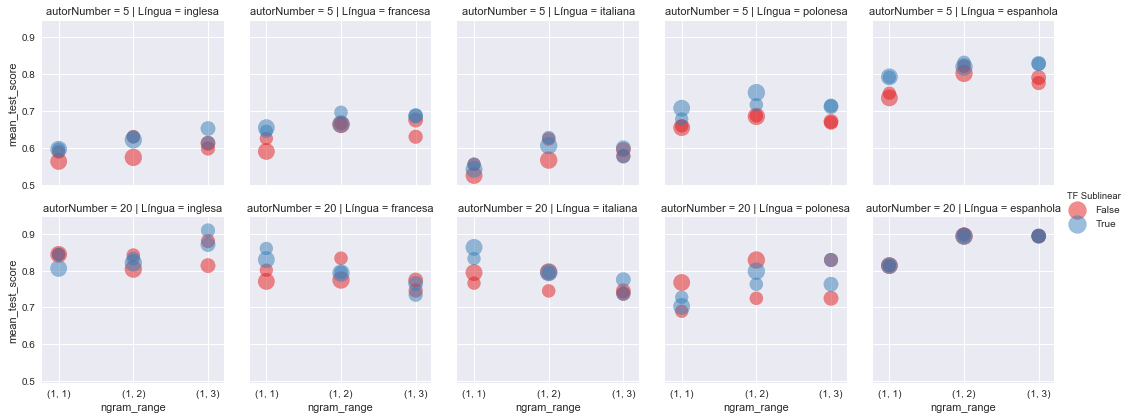

In [21]:
g = sns.FacetGrid(d, row='autorNumber', hue='TF Sublinear',  col=u"Língua", size=3,palette="Set1")
g.map(plt.scatter, "ngram_range", "mean_test_score", alpha=0.5, s=d.std_test_score.values).add_legend();

In [22]:
import statsmodels.api as sm

/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [23]:
d = dfCV[['mean_test_score','problem', 'language','sublinear_tf','norm','ngram_range','PCA_componentes']].copy();
d.sublinear_tf=d.sublinear_tf.apply(lambda x: 1 if x else 0)
d['autorNumber'] = d.problem.map(lambda x: 20 if x % 2==0  else 5)
d.norm.fillna(value='None', inplace=True);
d.PCA_componentes = np.log(d.PCA_componentes);

_, d['ngram_max'] = zip(*d.ngram_range.str.replace(r'[^\d,]','').str.split(',').values.tolist())
#d.ngram_min = d.ngram_min.astype(np.uint8);
d.ngram_max = d.ngram_max.astype(np.uint8);
d.drop(columns=['ngram_range','problem'], inplace=True)
#d['intercept'] = 1;

d=pd.get_dummies(d, columns=['language', 'norm','ngram_max'])

In [24]:
d.describe()

,mean_test_score,sublinear_tf,PCA_componentes,autorNumber,language_espanhola,language_francesa,language_inglesa,language_italiana,language_polonesa,norm_None,norm_l1,norm_l2,ngram_max_1,ngram_max_2,ngram_max_3
count,1080.000,1080.0,1080.000,1080.000,1080.0,1080.0,1080.0,1080.0,1080.0,1080.000,1080.000,1080.000,1080.000,1080.000,1080.000
mean,0.547,0.5,-0.796,12.500,0.2,0.2,0.2,0.2,0.2,0.333,0.333,0.333,0.333,0.333,0.333
std,0.220,0.5,0.816,7.503,0.4,0.4,0.4,0.4,0.4,0.472,0.472,0.472,0.472,0.472,0.472
min,0.079,0.0,-2.303,5.000,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.369,0.0,-1.386,5.000,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.589,0.5,-0.490,12.500,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.730,1.0,-0.105,20.000,0.0,0.0,0.0,0.0,0.0,1.000,1.000,1.000,1.000,1.000,1.000
max,0.909,1.0,-0.001,20.000,1.0,1.0,1.0,1.0,1.0,1.000,1.000,1.000,1.000,1.000,1.000


In [25]:
mod = sm.OLS( d.iloc[:,0], d.iloc[:,1:])
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        mean_test_score   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     500.7
Date:                Fri, 11 May 2018   Prob (F-statistic):               0.00
Time:                        00:57:34   Log-Likelihood:                 1084.1
No. Observations:                1080   AIC:                            -2144.
Df Residuals:                    1068   BIC:                            -2084.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
sublinear_tf           0.0452      0.005      8.322      0.000       0.035       0.056
PCA_componentes        0.2079      0.003     62.514      0.000       0.201       0.214
autorNumber            0.0120      0.000     33.185      0.000       0.011       0.013
language_espanhola     0.1879      0.006     33.373      0.000       0.177       0.199
language_francesa      0.1254      0.006     22.264      0.000       0.114       0.136
language_inglesa       0.0943      0.006     16.741      0.000       0.083       0.105
language_italiana      0.1017      0.006     18.062      0.000       0.091       0.113
language_polonesa      0.1136      0.006     20.184      0.000       0.103       0.125
norm_None              0.1579      0.005     34.473      0.000       0.149       0.167
norm_l1                0.2620      0.005     57.215      0.000       0.253       0.271
norm_l2                0.2030      0.005     44.334      0.000       0.194       0.212
ngram_max_1            0.2253      0.005     49.201      0.000       0.216       0.234
ngram_max_2            0.2090      0.005     45.642      0.000       0.200       0.218
ngram_max_3            0.1886      0.005     41.178      0.000       0.180       0.198
==============================================================================
Omnibus:                       13.048   Durbin-Watson:                   1.003
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.993
Skew:                          -0.220   Prob(JB):                     0.000915
Kurtosis:                       3.344   Cond. No.                     1.04e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.12e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

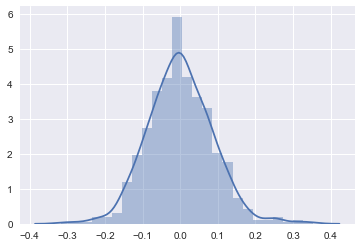

In [53]:
sns.distplot(res.predict()-d.iloc[:,0].values, bins=25)

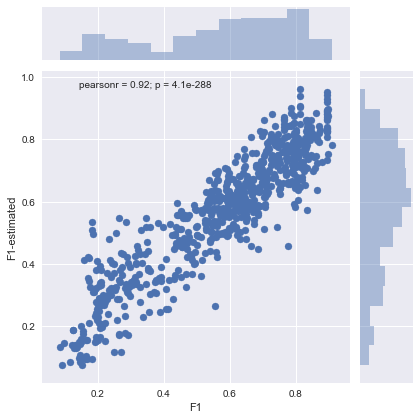

In [54]:
sns.jointplot(x='F1',y='F1-estimated',data=pd.DataFrame({'F1':d.iloc[:,0].values, 'F1-estimated':res.predict()}));

<br/><br/><br/><br/><br/>

#  Abordagem desafiante 1

In [ ]:
from gensim.models import Word2Vec;

In [ ]:
class NgramSplitter(object):
    def __init__(self, text, ngram=(3,3), vocabulary=None):
        self.text = text
        self.ngram_min = ngram[0]
        self.ngram_max = ngram[1];
        self.vocabulary = vocabulary;
    
    def text2ngrams(self,text):
        vect = [
            text[t:t+j]
                for t in xrange(len(text)-self.ngram_max+1)
                for j in xrange(self.ngram_min, self.ngram_max+1)
        ]
        
        if self.vocabulary is not None:
            return [word for word in vect if word in self.vocabulary];
        else:
            return [word for word in vect if word]
 
    def __iter__(self):
        if isinstance(self.text,list):
            for s in self.text:
                yield self.text2ngrams(s);
        elif isinstance(self.text,str) or isinstance(self.text,unicode):
            yield self.text2ngrams(self.text);

In [ ]:
class Word2VecClassifier(BaseEstimator, ClassifierMixin):  
    """A classifier that uses classes embeddings to classify instances"""
    
    def __init__(
            self,
            ngram = (3,4),
            analyzer = 'char',
            min_df = 0.3,
            max_df = 1.0,
        
            min_count =2,
            embeddingSize =750,
            window=10,
            algorithm = 0,
            iter =10
        ):
        """
        Called when initializing the classifier
        """
        self.algorithm     = algorithm
        self.min_count     = min_count
        self.embeddingSize = embeddingSize
        self.window        = window
        self.iter          = iter
        self.analyzer      = analyzer
        self.vocabulary_   = {}
        self.ngram         = ngram
        self.min_df        = min_df
        self.max_df        = max_df

    def _buildVectorModel(self, document):
        sentenseGenerator = NgramSplitter(document,self.ngram, self.vocabulary_);
        
        model = Word2Vec(
            sentenseGenerator,
            sg       = self.algorithm,
            iter     = self.iter,        
            min_count= self.min_count,
            window   = self.window,
            size     = self.embeddingSize,
            seed=0
        );
        return model.wv;
        
    def fit(self, X, y=None):
        """
        Sumarize one text per labels and transform the text into word vectors
        """
        
        #creating author profile
        profile = defaultdict(unicode);
        for text, label in zip(X,y):
            profile[label]+=text;
            
        #build a global vocaculary / Using count vectorizer to create a fixed vocabulary
        vectorizer = CountVectorizer(
                analyzer=self.analyzer,
                ngram_range=self.ngram,
                min_df=self.min_df,
                max_df=self.max_df,
                lowercase=False
        )
        vectorizer.fit(X);
        self.vocabulary_ = vectorizer.vocabulary_
        
        # profile vector represent each author in the embedding space
        self.profileVectors_ = {y: self._buildVectorModel(profile[y]) for y in y};

        return self
    
    
    def _minmax(self, a):
        a = (a - a.min())/(a.max() - a.min());
        return a;
        
    def _simpleCosine(self,a, b):
        '''
        calculates cosine between array a and b.
        This function is used because sklearn similiraty function compares all elements vs all elements
        what will not be used. So this function becames handy.
        '''
        a = a / np.sqrt(np.sum(a **2));
        b = b / np.sqrt(np.sum(b **2));
        cos = np.sum(np.array(a) * np.array(b));
        return cos;
    
    def _KLD(self,p, q):
        p = self._minmax(p); p = p/p.sum();
        q = self._minmax(q); q = q/q.sum();
        
        cond = ((q != 0)&(p != 0));
        k1 = np.sum(np.where(cond, p * np.log(p / q), 0));
        return k1;
    
    def _manhattan(self,p, q):
        p = self._minmax(p); p = p/p.sum();
        q = self._minmax(q); q = q/q.sum();
        return np.mean(np.abs(p-q));
    
    
    def _guassian(self, C,D):
        cond = C-D !=0;
        bc = np.where(cond,(C-D+1)**2/(2*np.maximum(C,D+1)),1);
        return np.sum(-np.log(bc));


    def score(self, X, y=None):
        # counts number of values bigger than mean
        return(sum(self.predict(X)))
    
    def _softMax(self,a):
        a = self._minmax(a);
        a = np.exp(a)/np.sum(np.exp(a))
        return a;
    
    def _predict1Doc(self, docVect):
        vocabDoc = set(docVect.vocab.keys());
    
        metrics = [];
        
        def c(aa,bb, funct):
            voc = set(aa.vocab.keys()) & set(bb.vocab.keys())
            f = np.array([
                funct(aa[v], bb[v])
                for v in voc
            ]);
            f = np.sum(f)
            return f;
    
        for label in self.profileVectors_:
            labelVocab = set(self.profileVectors_[label].vocab.keys());
            intersect  = vocabDoc & labelVocab;
            union      = len(vocabDoc | labelVocab);
            jaccard    = 1.0*len(intersect) / union;
            
            metrics.append({
                'label'       : label,
                'jaccard'     : jaccard,
                'lenIntersect': len(intersect),
                'lenUnion'    : union,
                'lenMax'      : max(len(labelVocab), len(vocabDoc)),
                'similarity'  : c(docVect, self.profileVectors_[label], self._simpleCosine),
                'KLD'         : c(docVect, self.profileVectors_[label], self._KLD),
                'manhattan'   : c(docVect, self.profileVectors_[label], self._manhattan),
                'guassian'    : c(docVect, self.profileVectors_[label], self._guassian),
                
            })
        #softmax norm
        similarity = self._softMax(np.array([c['similarity'] for c in metrics ]));
        guassian   = self._softMax(np.array([c['guassian'] for c in metrics ]));
        manhattan  = self._softMax(np.array([c['manhattan'] for c in metrics ]));
    
        #appending normalized sum of distance
        for i,c in enumerate(metrics):
            c.update({
                'similarityNorm': similarity[i],
                'guassianNorm': guassian[i],
                'manhattanNorm': manhattan[i]
            })
    
        return metrics;
    
    def predict(self, X, y=None):
        try:
            getattr(self, "profileVectors_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
            
        docVectors    = [self._buildVectorModel(x) for x in X];
        self.metrics_ = [self._predict1Doc(v)      for v in docVectors];
        
        result = [];
        for r in self.metrics_:
            best = r[0];
            best['bestMatch'] = True;
            for rr in r:
                if rr != best:
                    rr['bestMatch'] = False;
                if rr['similarityNorm'] > best['similarityNorm'] :
                    best['bestMatch'] = False;
                    best = rr;
                    best['bestMatch'] = True;
            result.append(best);
            
        self.predited_ = result;

        return([r['label'] for r in result])

In [ ]:
problem = problems[8];
print ("Problem: %s,  language: %s, " %(problem['problem'],problem['language']))

In [ ]:
model = Word2VecClassifier();

In [ ]:
train_docs, train_labels,_ = zip(*problem['candidates']);

In [ ]:
model.fit(train_docs,train_labels);

In [ ]:
trainPred = model.predict(train_docs);
trainMetrics = model.metrics_;

In [ ]:
df=pd.DataFrame(zip(train_labels,trainPred), columns=['label','pred'])
df.label = df.label.apply(lambda x: int(re.sub(r'\D','',x)));
df.pred = df.pred.apply(lambda x: int(re.sub(r'\D','',x)));
df.plot.scatter(x='label',y='pred');

In [ ]:
m  = trainMetrics
df = pd.DataFrame([item for s in m for item in s])
df['doc']      = [i               for i,s in enumerate(m) for item in s]
df['solution'] = [train_labels[i] for i,s in enumerate(m) for item in s]
df.sort_values(by=['doc','similarityNorm', 'manhattan'], ascending=[True,False,True], inplace=True)
df['distance'] = [i for i in range(len(set(train_labels)))]* len(trainMetrics)
df[df.doc == 55]

In [ ]:
df2 = df[df.bestMatch].copy();
df2['correct'] = df2.apply(lambda x: x['label'] == x['solution'], axis=1)
df2[['correct','doc']].groupby(by='correct').count()

In [ ]:
model.get_params()

In [ ]:
df2 = df[df.bestMatch].copy();
df2['correct'] = df2.apply(lambda x: x['label'] == x['solution'], axis=1)
df2[['correct','doc']].groupby(by='correct').count()

In [ ]:
model.get_params()

In [ ]:
df[df.solution == df.label].plot.scatter(x='distance', y='manhattanNorm')
df[df.solution == df.label].plot.scatter(x='distance', y='guassianNorm')
df[df.solution == df.label].plot.scatter(x='distance', y='similarityNorm')
df[df.solution == df.label].plot.scatter(x='manhattanNorm', y='guassianNorm', c='distance',colormap='Reds')

### test

In [ ]:
#code from baseline
gt = {}
with open(pathjoin(inputDir, problem['problem'], 'ground-truth.json'), 'r') as f:
    for attrib in json.load(f)['ground_truth']:
        gt[attrib['unknown-text']] = attrib['true-author']

In [ ]:
test_docs, _, test_filename = zip(*problem['unknown'])
test_labels = [gt[v] for v in test_filename]

In [ ]:
testPred = model.predict(test_docs);
testMetrics = model.metrics_;

In [ ]:
m  = testMetrics
df = pd.DataFrame([item for s in m for item in s])
df['doc']      = [i               for i,s in enumerate(m) for item in s]
df['solution'] = [train_labels[i] for i,s in enumerate(m) for item in s]
df.sort_values(by=['doc','similarityNorm', 'KLD'], ascending=[True,False,True], inplace=True)
df['distance'] = [i for i in range(len(set(train_labels)))]* len(testMetrics)
df[df.doc == 55]

In [ ]:
f1,precision,recall,accuracy =  eval_measures(gt,{k: v for k,v in zip(test_filename, testPred)  })

In [ ]:
pd.DataFrame([{
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3)
             }])

In [ ]:
df2 = df[df.bestMatch].copy();
df2['correct'] = df2.apply(lambda x: x['label'] == x['solution'], axis=1)
df2[['correct','doc']].groupby(by='correct').count()

In [ ]:
df[df.solution == df.label].plot.scatter(x='distance', y='guassianNorm')
df[df.solution == df.label].plot.scatter(x='distance', y='manhattanNorm')
df[df.solution == df.label].plot.scatter(x='distance', y='similarityNorm')

In [ ]:
df[df.solution == df.label]\
    .plot\
    .scatter(
        x='guassianNorm',
        y='similarityNorm',
        c='distance',
        colormap='Reds',
        figsize=(20,5));